In [1]:
# Here we take care of paths.

from pathlib import Path
import os
print('Starting path:' + os.getcwd())
if os.getcwd()[-16:] == 'image-to-tex-OCR':
    pass
else:
    PATH = Path().resolve().parents[0]
    os.chdir(PATH)

# make sure you are in Paragraph_to_Tex folder
print('Current path:' + os.getcwd())

Starting path:/Users/gregory/PROJECT_ML/PROJECT_AMINE/image-to-tex-OCR/Jupyter_Notebooks
Current path:/Users/gregory/PROJECT_ML/PROJECT_AMINE/image-to-tex-OCR


In [2]:
from Data.Data_Module import Data_Module
from Models.Printed_Tex_Transformer import ResNetTransformer
from Lightning_Models.Printed_Tex_Lit_Model import LitResNetTransformer
import numpy as np
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from PIL import Image
import torch
from pytorch_lightning.loggers import TensorBoardLogger
from torchvision import transforms
from PIL import Image
from IPython.display import display, Math
from Data.image_transforms import Image_Transforms
import cv2
import cv2
import PIL
import numpy as np
transform = transforms.ToPILImage()


dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


In [3]:
# Generate Data Module by uploading images and formulas
# images need to be in the folder Data/Data_Bank/generated_png_images
# formulas need to be in Data/Data_Bank/final_png_formulas.txt
# image filenames need to be in Data/Data_Bank/corresponding_png_images.txt

dataset = Data_Module(stage = 'fit',
                 set_max_label_length = 128,
                 number_png_images_to_use_in_dataset=250*1000,
                 labels_transform='default',
                image_transform_name ='alb',
                 train_val_fraction = 0.999,
                   vocabulary_path = 'Data/Data_Bank/230k.json',
                load_vocabulary = True,
                      image_padding = True,


                 batch_size = 128,
                num_workers = 8,
                data_on_gpu = True,
                )


In [4]:
print( 
    'Vocabulary size:',len(dataset.vocabulary),
    '\nMax label length:', dataset.max_label_length,
    "\nStart <S> goes to index ",dataset.vocabulary['<S>'],
      "\nEnd <E> goes to index ",dataset.vocabulary['<E>'],
      "\nPadding <P> goes to index ",dataset.vocabulary['<P>'],
)

Vocabulary size: 579 
Max label length: 130 
Start <S> goes to index  0 
End <E> goes to index  1 
Padding <P> goes to index  2


In [5]:
MAX_RATIO = 15


# HELPER FUNCTIONS
def token_to_strings(tokens):
    mapping = dataset.vocabulary
    inverse_mapping =dataset.inverse_vocabulary
    s=''
    if tokens.shape[0] ==1:
        tokens = tokens[0]
    for number in tokens:
        letter = inverse_mapping[number.item()]
        s= s +" " + str(letter)
    return s
def findPositions(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    gray = 255*(gray < 50).astype(np.uint8)  # To invert the text to white
    gray = cv2.morphologyEx(gray, cv2.MORPH_OPEN, np.ones((2, 2), dtype=np.uint8))  # Perform noise filtering
    coords = cv2.findNonZero(gray)  # Find all non-zero points (text)
    x, y, w, h = cv2.boundingRect(coords)  # Find minimum spanning bounding box
    # Crop the image - note we do this on the original image
    cropped_image = image[y-10:y+h+10, x-10:x+w+10]

    return cropped_image


In [6]:
# Load with pytorch epoch=4-step=17280.ckpt

model = ResNetTransformer(dataset=dataset).to(dev)
model.load_state_dict(torch.load(("Models_Parameters_Log/Collate1.pth"), map_location=torch.device('cpu')))
lit_model = LitResNetTransformer(model=model, WandB=False)
scripted_save = lit_model.to_torchscript()
torch.jit.save(scripted_save, "Models_Parameters_Log/scripted_model1.pt")


/Users/gregory/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/gregory/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/Users/gregory/opt/anaconda3/lib/python3.9/site-packages/torch/jit/_recursive.py:262: UserWarning: 'batch_first' was found in ScriptModule constants, but was not actually set in __init__. Consider removing it.
  warnings.warn("'{}' was found in ScriptModule constants, "


In [7]:
scripted = torch.jit.load("Models_Parameters_Log/scripted_model1.pt")

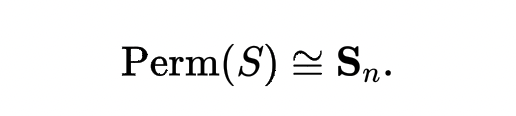

None
torch.Size([1, 128, 512])


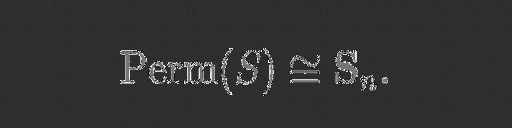

None

Predicted formula:
 <S> \tag { } { \bf x } \sum _ { \bf x } { \bf x } \sum _ { \bf x } = \sum _ { \bf x } \sum _ { \bf x } \sum _ { \bf x } \sum _ { \bf x } = { \bf P } } { \bf P } _ { \bf x } { \bf p } } \mathrm { \Large ~ p f ~ a } \tag { x } { \bf x } \mathrm { \Large ~ p f ~ a } \tag { x } <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None


In [23]:
image_path= "Jupyter_Notebooks/test_photos/zarhin.png"
image = Image.open(image_path).convert('RGB')
image = np.asarray(image)
#image = findPositions(image)
print(display(transform(image)))


h, w, c = image.shape
ratio =int(w / h)
if ratio == 0:
    ratio = 1 
if ratio > MAX_RATIO:
    ratio = MAX_RATIO


new_h = 128
new_w = int(new_h * ratio)
if h >128:
    image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)
else:
    image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_CUBIC)


    
image_tensor = Image_Transforms.test_transform_with_padding(image=np.array(image))['image'][:1]
print(image_tensor.shape)
print(display(transform(image_tensor))) 

#prediction =  scripted_model(my_image_tensor.unsqueeze(0).to(dev))
print('\nPredicted formula:')
prediction =  scripted(image_tensor.unsqueeze(0))
print(token_to_strings(prediction))
print(display(Math(token_to_strings(prediction))))

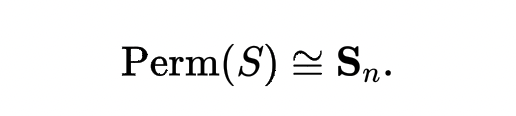

None
torch.Size([1, 128, 512])


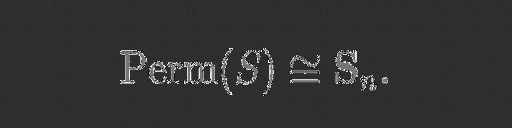

None

Predicted formula:
 <S> \tag { } { \bf x } \sum _ { \bf x } { \bf x } \sum _ { \bf x } = \sum _ { \bf x } \sum _ { \bf x } \sum _ { \bf x } \sum _ { \bf x } = { \bf P } } { \bf P } _ { \bf x } { \bf p } } \mathrm { \Large ~ p f ~ a } \tag { x } { \bf x } \mathrm { \Large ~ p f ~ a } \tag { x } <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None


In [8]:
image_path= "Jupyter_Notebooks/test_photos/zarhin.png"
image = Image.open(image_path).convert('RGB')
image = np.asarray(image)
#image = findPositions(image)
print(display(transform(image)))


h, w, c = image.shape
ratio =int(w / h)
if ratio == 0:
    ratio = 1 
if ratio > MAX_RATIO:
    ratio = MAX_RATIO


new_h = 128
new_w = int(new_h * ratio)
if h >128:
    image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)
else:
    image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_CUBIC)


    
image_tensor = Image_Transforms.test_transform_with_padding(image=np.array(image))['image'][:1]
print(image_tensor.shape)
print(display(transform(image_tensor))) 

#prediction =  scripted_model(my_image_tensor.unsqueeze(0).to(dev))
print('\nPredicted formula:')
prediction =  scripted(image_tensor.unsqueeze(0))
print(token_to_strings(prediction))
print(display(Math(token_to_strings(prediction))))

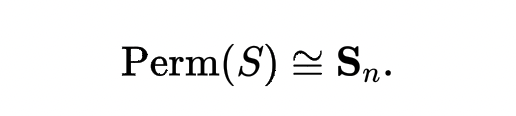

None
torch.Size([1, 128, 512])


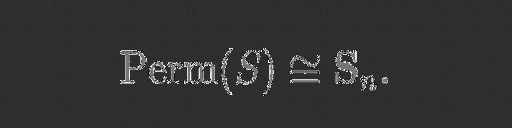

None

Predicted formula:
 <S> \tag { } { \bf x } \sum _ { \bf x } { \bf x } \sum _ { \bf x } = \sum _ { \bf x } \sum _ { \bf x } \sum _ { \bf x } \sum _ { \bf x } = { \bf P } } { \bf P } _ { \bf x } { \bf p } } \mathrm { \Large ~ p f ~ a } \tag { x } { \bf x } \mathrm { \Large ~ p f ~ a } \tag { x } <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None


In [9]:
image_path= "Jupyter_Notebooks/test_photos/zarhin.png"
image = Image.open(image_path).convert('RGB')
image = np.asarray(image)
#image = findPositions(image)
print(display(transform(image)))


h, w, c = image.shape
ratio =int(w / h)
if ratio == 0:
    ratio = 1 
if ratio > MAX_RATIO:
    ratio = MAX_RATIO


new_h = 128
new_w = int(new_h * ratio)
if h >128:
    image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)
else:
    image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_CUBIC)


    
image_tensor = Image_Transforms.test_transform_with_padding(image=np.array(image))['image'][:1]
print(image_tensor.shape)
print(display(transform(image_tensor))) 

#prediction =  scripted_model(my_image_tensor.unsqueeze(0).to(dev))
print('\nPredicted formula:')
prediction =  scripted(image_tensor.unsqueeze(0))
print(token_to_strings(prediction))
print(display(Math(token_to_strings(prediction))))

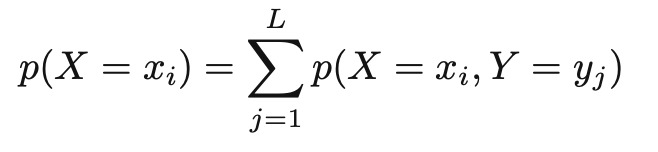

None
torch.Size([1, 128, 512])


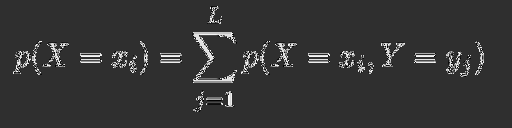

None

Predicted formula:
 <S> \begin{array} { c c c c c c c c c c c c c c } { \displaystyle { \displaystyle { \displaystyle { \displaystyle { \displaystyle { \displaystyle { \displaystyle { \displaystyle { \displaystyle { \displaystyle { \displaystyle { \displaystyle { \displaystyle { \displaystyle { \displaystyle { \displaystyle { \displaystyle { \displaystyle { { \displaystyle { \displaystyle { \displaystyle { \displaystyle { \displaystyle { \displaystyle { \displaystyle { \displaystyle { { \displaystyle { { \displaystyle { { \displaystyle { { \displaystyle { { { { { { { P } } } } } } } } & { { { \bf { { { { { { { { { { { { { { { { { { { { { { { { { {


<IPython.core.display.Math object>

None


In [10]:
image_path= "Jupyter_Notebooks/test_photos/screenshot_1.png"
image = Image.open(image_path).convert('RGB')
image = np.asarray(image)
#image = findPositions(image)
print(display(transform(image)))


h, w, c = image.shape
ratio =int(w / h)
if ratio == 0:
    ratio = 1 
if ratio > MAX_RATIO:
    ratio = MAX_RATIO


new_h = 128
new_w = int(new_h * ratio)
if h >128:
    image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)
else:
    image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_CUBIC)


    
image_tensor = Image_Transforms.test_transform_with_padding(image=np.array(image))['image'][:1]
print(image_tensor.shape)
print(display(transform(image_tensor))) 

#prediction =  scripted_model(my_image_tensor.unsqueeze(0).to(dev))
print('\nPredicted formula:')
prediction =  scripted(image_tensor.unsqueeze(0))
print(token_to_strings(prediction))
print(display(Math(token_to_strings(prediction))))

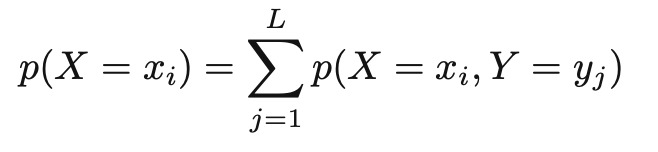

None
torch.Size([1, 128, 512])


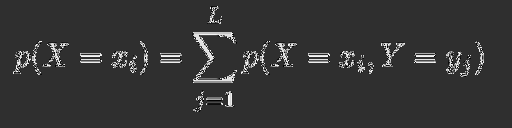

None

Predicted formula:
 <S> \begin{array} { c c c c c c c c c c c c c c } { \displaystyle { \displaystyle { \displaystyle { \displaystyle { \displaystyle { \displaystyle { \displaystyle { \displaystyle { \displaystyle { \displaystyle { \displaystyle { \displaystyle { \displaystyle { \displaystyle { \displaystyle { \displaystyle { \displaystyle { \displaystyle { { \displaystyle { \displaystyle { \displaystyle { \displaystyle { \displaystyle { \displaystyle { \displaystyle { \displaystyle { { \displaystyle { { \displaystyle { { \displaystyle { { \displaystyle { { { { { { { P } } } } } } } } & { { { \bf { { { { { { { { { { { { { { { { { { { { { { { { { {


<IPython.core.display.Math object>

None


In [11]:
image_path= "Jupyter_Notebooks/test_photos/screenshot_1.png"
image = Image.open(image_path).convert('RGB')
image = np.asarray(image)
#image = findPositions(image)
print(display(transform(image)))


h, w, c = image.shape
ratio =int(w / h)
if ratio == 0:
    ratio = 1 
if ratio > MAX_RATIO:
    ratio = MAX_RATIO


new_h = 128
new_w = int(new_h * ratio)
if h >128:
    image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)
else:
    image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_CUBIC)


    
image_tensor = Image_Transforms.test_transform_with_padding(image=np.array(image))['image'][:1]
print(image_tensor.shape)
print(display(transform(image_tensor))) 

#prediction =  scripted_model(my_image_tensor.unsqueeze(0).to(dev))
print('\nPredicted formula:')
prediction =  scripted(image_tensor.unsqueeze(0))
print(token_to_strings(prediction))
print(display(Math(token_to_strings(prediction))))

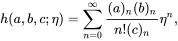

None
torch.Size([1, 128, 512])


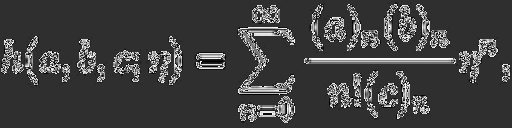

None

Predicted formula:
 <S> \begin{array} { c c c c c c c c c c c c c c c } { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } &


<IPython.core.display.Math object>

None


In [12]:
image_path= "Jupyter_Notebooks/test_photos/0a0df4c4229b725.png"
image = Image.open(image_path).convert('RGB')
image = np.asarray(image)
#image = findPositions(image)
print(display(transform(image)))


h, w, c = image.shape
ratio =int(w / h)
if ratio == 0:
    ratio = 1 
if ratio > MAX_RATIO:
    ratio = MAX_RATIO


new_h = 128
new_w = int(new_h * ratio)
if h >128:
    image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)
else:
    image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_CUBIC)


    
image_tensor = Image_Transforms.test_transform_with_padding(image=np.array(image))['image'][:1]
print(image_tensor.shape)
print(display(transform(image_tensor))) 

#prediction =  scripted_model(my_image_tensor.unsqueeze(0).to(dev))
print('\nPredicted formula:')
prediction =  scripted(image_tensor.unsqueeze(0))
print(token_to_strings(prediction))
print(display(Math(token_to_strings(prediction))))

(23, 57, 3)


None
torch.Size([1, 128, 256])


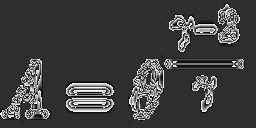

None

Predicted formula:
 <S> \begin{array} { c c c c c c c c c c c c c c c c c c c c } { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & {


<IPython.core.display.Math object>

None


In [13]:
image_path= "Jupyter_Notebooks/test_photos/0a0ebebfb1f6ab3.png"
image = Image.open(image_path).convert('RGB')
image = np.asarray(image)
#image = findPositions(image)
print(image.shape)
print(display(transform(image)))


h, w, c = image.shape
ratio =int(w / h)
if ratio == 0:
    ratio = 1 
if ratio > MAX_RATIO:
    ratio = MAX_RATIO


new_h = 128
new_w = int(new_h * ratio)
if h >128:
    image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)
else:
    image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_CUBIC)


    
image_tensor = Image_Transforms.test_transform_with_padding(image=np.array(image))['image'][:1]
print(image_tensor.shape)
print(display(transform(image_tensor))) 

#prediction =  scripted_model(my_image_tensor.unsqueeze(0).to(dev))
print('\nPredicted formula:')
prediction =  scripted(image_tensor.unsqueeze(0))
print(token_to_strings(prediction))
print(display(Math(token_to_strings(prediction))))

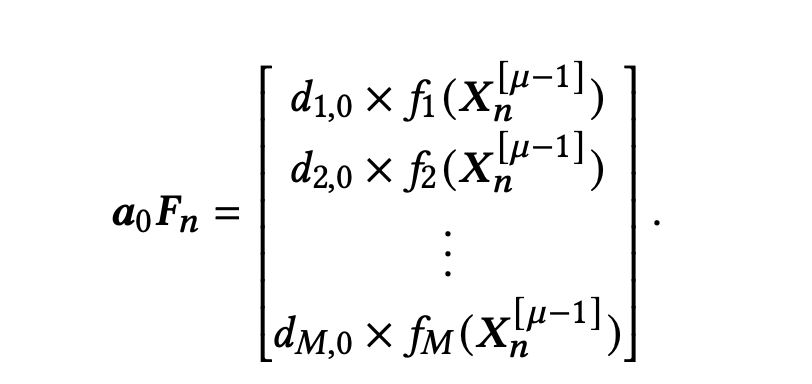

None
2.1145833333333335
torch.Size([1, 128, 270])


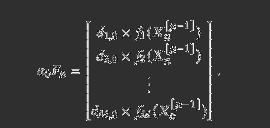

None

Predicted formula:
 <S> \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad d _ { 0 } { \bf P } _ { 1 0 } { \bf P } _ { 2 } ( { \bf P } _ { 2 } ( { \bf P } _ { 2 } ^ { ( \mu - 1 ) } ) } { d _ { \bf P } _ { 0 } { \bf P } _ { 2 } ( { \bf P } _ { 2 } ^ { ( \mu - 1 ) } ) } \\ { d { \bf B } M } & { \cal P } ( { \bf X } _ { H } ^ { ( \mu ) } 1


<IPython.core.display.Math object>

None


In [14]:

image_path= "Jupyter_Notebooks/test_photos/Screen Shot_11.png"
image = Image.open(image_path).convert('RGB')
image = np.asarray(image)
#image = findPositions(image)
print(display(transform(image)))


h, w, c = image.shape
ratio =(w / h)
print(ratio)
if ratio == 0:
    ratio = 1 
if ratio > MAX_RATIO:
    ratio = MAX_RATIO


new_h = 128
new_w = int(new_h * ratio)
if h >128:
    image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)
else:
    image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_CUBIC)


    
image_tensor = Image_Transforms.test_transform_with_padding(image=np.array(image))['image'][:1]
print(image_tensor.shape)
print(display(transform(image_tensor))) 

#prediction =  scripted_model(my_image_tensor.unsqueeze(0).to(dev))
print('\nPredicted formula:')
prediction =  scripted(image_tensor.unsqueeze(0))
print(token_to_strings(prediction))
print(display(Math(token_to_strings(prediction))))

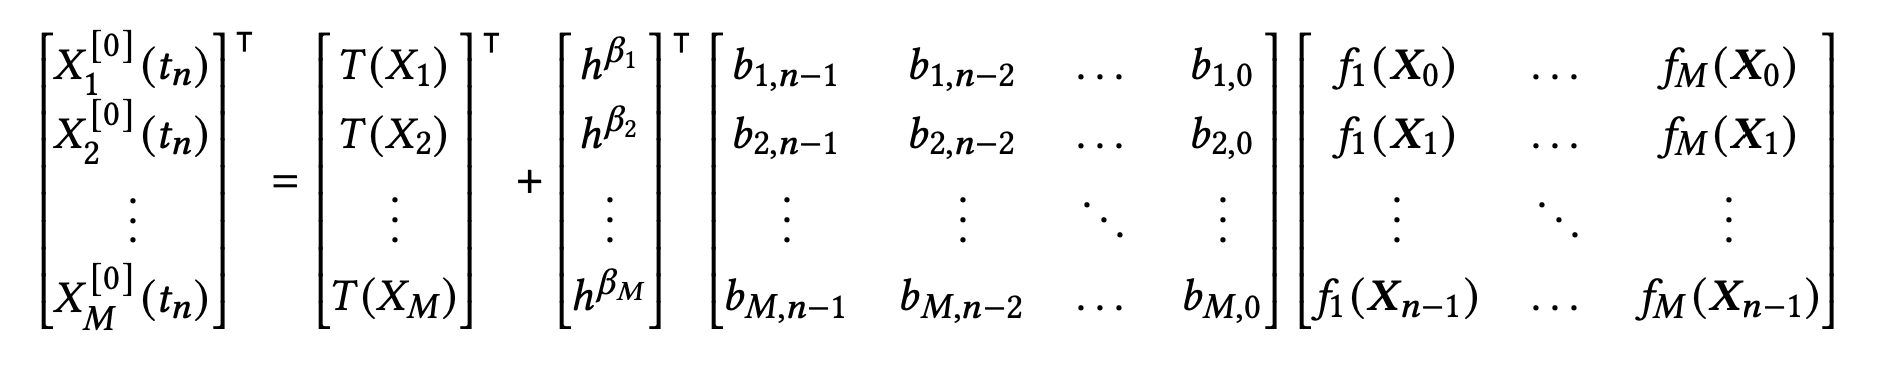

None
torch.Size([1, 128, 621])


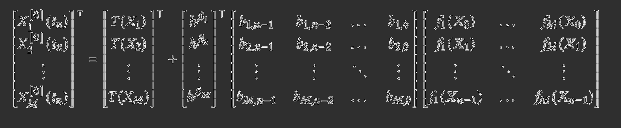

None

Predicted formula:
 <S> \begin{array} { l l l l } { [ X _ { 2 } ^ { \{ 0 \} } ( t a ) ] } \\ { [ { \cal Y } ( { \bf I } ) } \\ { { \cal Y } } & { = \left[ \begin{array} { c c c c c c c c c c } { T ( X _ { 1 } ) } \\ { \cal I } & { } & { } & { } & { { } & { { } & { { b ^ { 2 } } & { } & { b _ { 2 } a - 1 } & { b _ { 1 } } \\ {


<IPython.core.display.Math object>

None


In [15]:
image_path= "Jupyter_Notebooks/test_photos/Screen Shot_12.png"
image = Image.open(image_path).convert('RGB')
image = np.asarray(image)
#image = findPositions(image)
print(display(transform(image)))


h, w, c = image.shape
ratio =(w / h)
if ratio == 0:
    ratio = 1 
if ratio > MAX_RATIO:
    ratio = MAX_RATIO


new_h = 128
new_w = int(new_h * ratio)
if h >128:
    image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)
else:
    image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_CUBIC)


    
image_tensor = Image_Transforms.test_transform_with_padding(image=np.array(image))['image'][:1]
print(image_tensor.shape)
print(display(transform(image_tensor))) 

#prediction =  scripted_model(my_image_tensor.unsqueeze(0).to(dev))
print('\nPredicted formula:')
prediction =  scripted(image_tensor.unsqueeze(0))
print(token_to_strings(prediction))
print(display(Math(token_to_strings(prediction))))

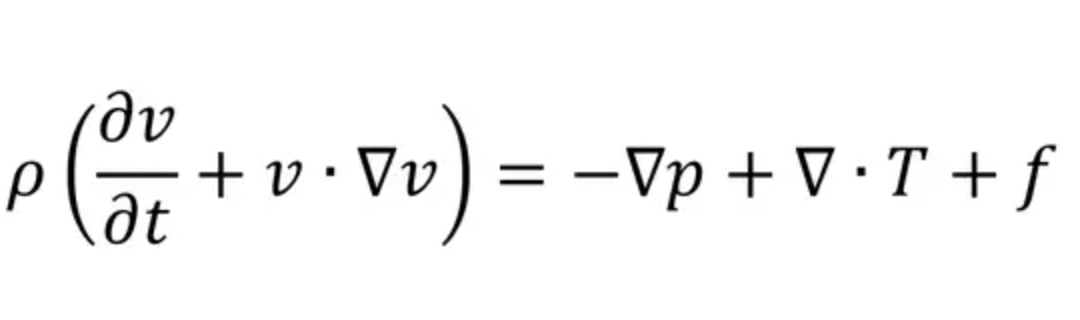

None
torch.Size([1, 128, 432])


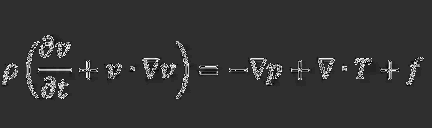

None

Predicted formula:
 <S> P \left\{ \begin{array} { l l l } { \bigotimes _ { \bf P } } & { } & { } \\ { { { \bf P } } } & { } & { } & { } & { } & { } \\ { { \bf P } } & { } & { { \bf P } } & { } & { { \bf P } } \\ \end{array} \right. } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } \\ { { \bf P } } & { } & { } & { } & { } \\ \end{array} \right.


<IPython.core.display.Math object>

None


In [16]:
image_path= "Jupyter_Notebooks/test_photos/screenshot_3.png"
image = Image.open(image_path).convert('RGB')
image = np.asarray(image)
#image = findPositions(image)
print(display(transform(image)))


h, w, c = image.shape
ratio =(w / h)
if ratio == 0:
    ratio = 1 
if ratio > MAX_RATIO:
    ratio = MAX_RATIO


new_h = 128
new_w = int(new_h * ratio)
if h >128:
    image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)
else:
    image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_CUBIC)


    
image_tensor = Image_Transforms.test_transform_with_padding(image=np.array(image))['image'][:1]
print(image_tensor.shape)
print(display(transform(image_tensor))) 

#prediction =  scripted_model(my_image_tensor.unsqueeze(0).to(dev))
print('\nPredicted formula:')
prediction =  scripted(image_tensor.unsqueeze(0))
print(token_to_strings(prediction))
print(display(Math(token_to_strings(prediction))))

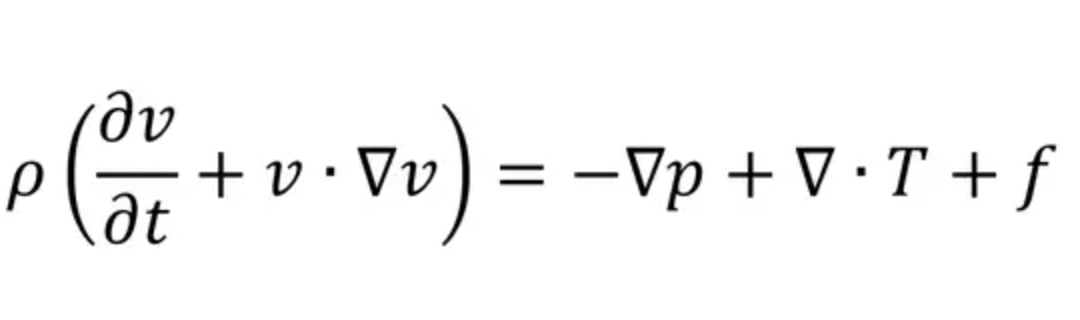

None
torch.Size([1, 128, 384])


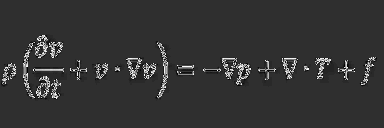

None

Predicted formula:
 <S> { \cal P } \left( \begin{array} { c c c c c c c c } { { { \bf P } } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } \\ { } &


<IPython.core.display.Math object>

None


In [17]:
image_path= "Jupyter_Notebooks/test_photos/screenshot_3.png"
image = Image.open(image_path).convert('RGB')
image = np.asarray(image)
#image = findPositions(image)
print(display(transform(image)))


h, w, c = image.shape
ratio =int(w / h)
if ratio == 0:
    ratio = 1 
if ratio > MAX_RATIO:
    ratio = MAX_RATIO


new_h = 128
new_w = int(new_h * ratio)
if h >128:
    image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)
else:
    image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_CUBIC)


    
image_tensor = Image_Transforms.test_transform_with_padding(image=np.array(image))['image'][:1]
print(image_tensor.shape)
print(display(transform(image_tensor))) 

#prediction =  scripted_model(my_image_tensor.unsqueeze(0).to(dev))
print('\nPredicted formula:')
prediction =  scripted(image_tensor.unsqueeze(0))
print(token_to_strings(prediction))
print(display(Math(token_to_strings(prediction))))

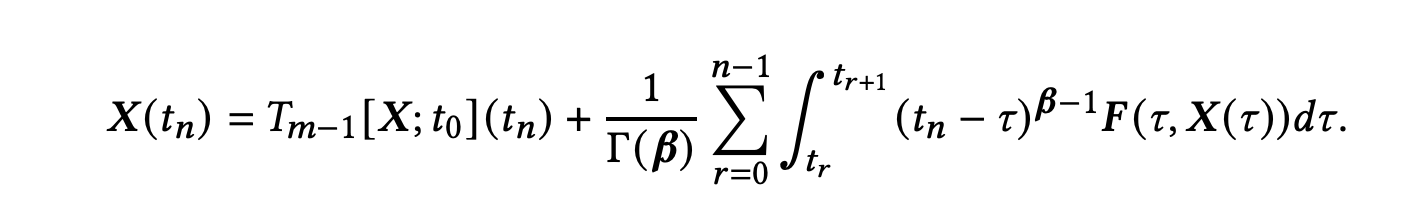

None
torch.Size([1, 128, 896])


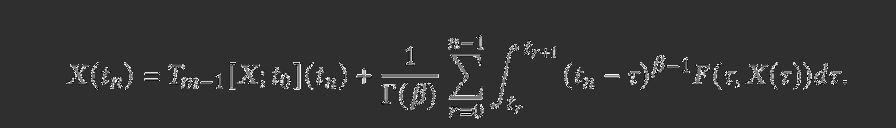

None

Predicted formula:
 <S> \bigoplus _ { \bf P } \left( \bigotimes _ { \bf P H } \right) \stackrel { \sim } { \longrightarrow } ~ \sum _ { \bf P } } { \bf P } } \sum _ { \bf P } } \left( \bigoplus _ { \bf P } \right) \left( \begin{array} { c c c } { \longrightarrow } & { \bf P } } & { \bf P } } & { \qquad } & { \qquad } & { \qquad } & { \qquad } & { \qquad } & { \qquad } & { \qquad } & { \qquad } & { \qquad } \\ { \bf P } = { \bf P } } \\ \end{array} \right) \mathrm { P } = \bigoplus _


<IPython.core.display.Math object>

None


In [18]:
image_path= "Jupyter_Notebooks/test_photos/Screen Shot_14.png"
image = Image.open(image_path).convert('RGB')
image = np.asarray(image)
#image = findPositions(image)
print(display(transform(image)))


h, w, c = image.shape
ratio =int(w / h)
if ratio == 0:
    ratio = 1 
if ratio > MAX_RATIO:
    ratio = MAX_RATIO


new_h = 128
new_w = int(new_h * ratio)
if h >128:
    image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)
else:
    image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_CUBIC)


    
image_tensor = Image_Transforms.test_transform_with_padding(image=np.array(image))['image'][:1]
print(image_tensor.shape)
print(display(transform(image_tensor))) 

#prediction =  scripted_model(my_image_tensor.unsqueeze(0).to(dev))
print('\nPredicted formula:')
prediction =  scripted(image_tensor.unsqueeze(0))
print(token_to_strings(prediction))
print(display(Math(token_to_strings(prediction))))

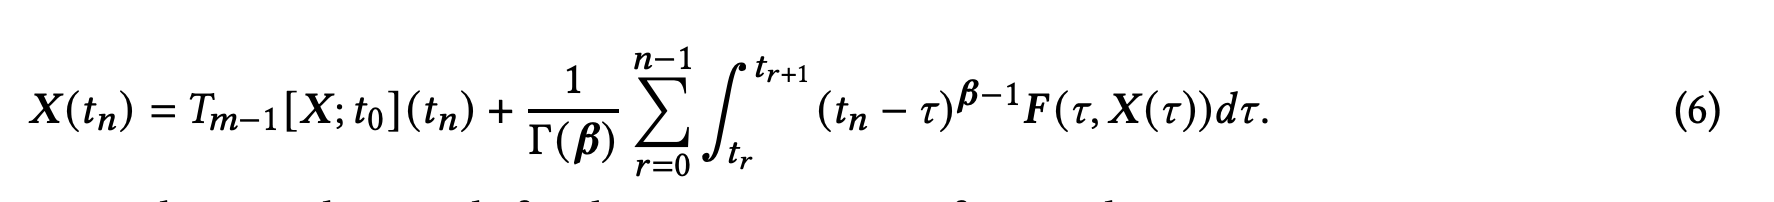

None
torch.Size([1, 41, 328])


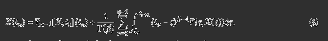

None

Predicted formula:
 <S> \textrm { X ( n ) \in \mathbb { T r e l } _ { n } ) \in \mathbb { L } _ { n } ^ { \mp i ( \mathcal { L } ) } _ { n } ^ { \mp } \int _ { n } ^ { \mp } \int _ { n } ^ { \mp } \int _ { n } ^ { \mp } \int _ { n } ^ { c _ { n } - i p _ { ( 7 , \mathrm { Z } ( 7 ) d \tau } . \qquad \qquad \qquad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad _ { 0 b b } <E>


<IPython.core.display.Math object>

None


In [25]:
image_path= "Jupyter_Notebooks/test_photos/Screen Shot_13.png"
image = Image.open(image_path).convert('RGB')
image = np.asarray(image)
#image = findPositions(image)
print(display(transform(image)))


h, w, c = image.shape
ratio =int(w / h)
if ratio == 0:
    ratio = 1 
if ratio > MAX_RATIO:
    ratio = MAX_RATIO


new_h = 41
new_w = int(new_h * ratio)
if h >128:
    image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)
else:
    image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_CUBIC)


    
image_tensor = Image_Transforms.test_transform_with_padding(image=np.array(image))['image'][:1]
print(image_tensor.shape)
print(display(transform(image_tensor))) 

#prediction =  scripted_model(my_image_tensor.unsqueeze(0).to(dev))
print('\nPredicted formula:')
prediction =  scripted(image_tensor.unsqueeze(0))
print(token_to_strings(prediction))
print(display(Math(token_to_strings(prediction))))

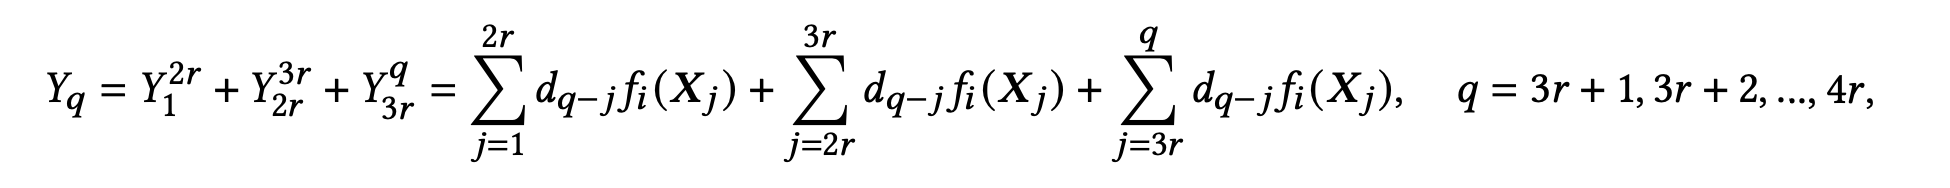

None
torch.Size([1, 128, 1280])


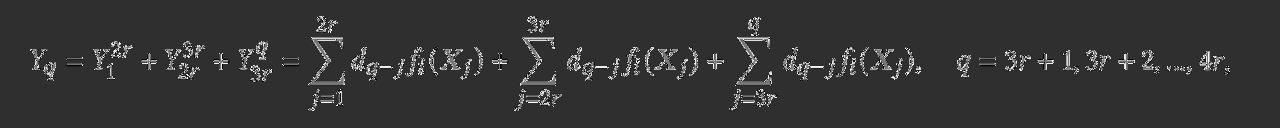

None

Predicted formula:
 <S> \begin{array} { c c c c c c c c } { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & { } & {


<IPython.core.display.Math object>

None


In [20]:
image_path=  "Jupyter_Notebooks/test_photos/Screen Shot_10.png"
image = Image.open(image_path).convert('RGB')
image = np.asarray(image)
#image = findPositions(image)
print(display(transform(image)))


h, w, c = image.shape
ratio =int(w / h)
if ratio == 0:
    ratio = 1 
if ratio > MAX_RATIO:
    ratio = MAX_RATIO


new_h = 128
new_w = int(new_h * ratio)
if h >128:
    image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)
else:
    image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_CUBIC)


    
image_tensor = Image_Transforms.test_transform_with_padding(image=np.array(image))['image'][:1]
print(image_tensor.shape)
print(display(transform(image_tensor))) 

#prediction =  scripted_model(my_image_tensor.unsqueeze(0).to(dev))
print('\nPredicted formula:')
prediction =  scripted(image_tensor.unsqueeze(0))
print(token_to_strings(prediction))
print(display(Math(token_to_strings(prediction))))